In [115]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier
import test as tt


### 文件读取、数据划分

In [121]:
def readfile():
    df = pd.read_csv('train_feature.csv')
    df.fillna(df.median(), inplace=True)
    X = np.array(df.values)
    y = np.loadtxt('train_label.csv', skiprows=1, dtype="int")
    df2 = pd.read_csv('test_feature.csv')
    df2.fillna(df2.median(), inplace=True)
    X2 = np.array(df2.values)
    return X, y, X2

def drop_err(X, y):
    out = []
    for i in range(X[0].size):
        t = abs(np.mean(X.T[i]))
        for j in range(X.shape[0]):
            if abs(X[j][i]) > t * 5e2:
                out.append(j)
    return np.delete(X, out, axis=0), np.delete(y, out)

def choose_feature(X, y, X2):
    clf = LR(penalty="l1")
    model = RFE(estimator=clf, n_features_to_select=85, step=5)
    X = model.fit_transform(X, y)
    X2 = model.transform(X2)
    model = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=60, step=5)
    X = model.fit_transform(X, y)
    X2 = model.transform(X2)
    return X, y, X2

def score(yp, y):
    return float(np.sum(yp == y))/y.size

X0, y0, X2 = readfile()
X0, y0 = drop_err(X0, y0)
X0, y0, X2 = choose_feature(X0, y0, X2)

In [117]:
def partition(X, y):
    t = (int)(0.7 * y.size)
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:(t-1),:]
    X_test = X[t:(y.size-1),:]
    y_train = y[0:(t-1)]
    y_test = y[t:(y.size-1)]
    return X_train, X_test, y_train, y_test

### 测试

In [118]:
def test(X0, y0, n):
    acc = np.zeros([5, n])
    dif = np.zeros([10, n])
    for j in range(n):
        X, X_t, y, y_t = partition(X0, y0)
        res = np.zeros([5, y_t.size], dtype="int")
        res[1] = tt.test_tree(X, y, X_t)
        res[2] = tt.test_mlp(X, y, X_t)
        res[3] = tt.test_xgb(X, y, X_t)
        res[4] = tt.test_svm(X, y, X_t)
        res[0] = tt.test_lr(X, y, X_t)
        for i in range(5):
            acc[i][j] = score(res[i], y_t)
        count = 0
        for i in range(4):
            for k in range(i+1, 5):
                dif[count][j] = 1 - score(res[i], res[k])
                count += 1
    return acc, dif

average acc:
[0.25110245 0.24899681 0.25048564 0.25142857 0.25453385]
lr's dif with other 4:
[0.739447   0.7467352  0.74238922 0.68472173]
tree's dif with other 3:
[0.74100674 0.70826657 0.73291032]
mlp's dif with other 2:
[0.73451258 0.73495923]
xgb's dif with svm:
[0.73929103]


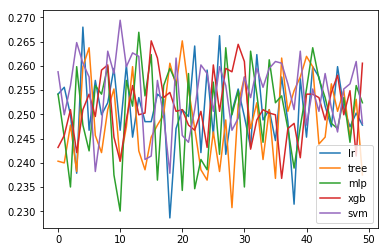

In [119]:
def draw_result(X0, y0, n):
    acc, dif = test(X0, y0, n)
    plt.plot(acc[0], label="lr")
    plt.plot(acc[1], label="tree")
    plt.plot(acc[2], label="mlp")
    plt.plot(acc[3], label="xgb")
    plt.plot(acc[4], label="svm")
    plt.legend()
    print("average acc:")
    print(np.average(acc, axis=1))
    dif_a = np.average(dif, axis=1)
    print("lr's dif with other 4:")
    print(dif_a[0:4])
    print("tree's dif with other 3:")
    print(dif_a[4:7])
    print("mlp's dif with other 2:")
    print(dif_a[7:9])
    print("xgb's dif with svm:")
    print(dif_a[9:10])
    
draw_result(X0, y0, 50)

### 输出

In [127]:
from SVM import SVM

def svm_mul(X, y, p, X_t, X2):
    r = SVM(X[0].size)
    y1 = y
    for j in range(y1.size):
        if y1[j] in p: y1[j] = 1
        else: y1[j] = -1
    r.fit(X, y1, choose_method="random", iter=60, C=1.5)
    return r.predict(X_t), r.predict(X2)

def test_svm(X, y, X_t, X2):
    yp1, p21 = svm_mul(X, y, [0,1], X_t, X2)
    yp2, p22 = svm_mul(X, y, [0,2], X_t, X2)
    yp3, p23 = svm_mul(X, y, [0,3], X_t, X2)
    yp4, p24 = svm_mul(X, y, [0], X_t, X2)
    yp5, p25 = svm_mul(X, y, [1], X_t, X2)
    yp6, p26 = svm_mul(X, y, [2], X_t, X2)
    yp7, p27 = svm_mul(X, y, [3], X_t, X2)
    yp = np.zeros(yp1.size, dtype="int")
    p2 = np.zeros(p21.size, dtype="int")
    x = np.zeros(4, dtype="int")
    for i in range(yp.size):
        now = np.array([yp1[i], yp2[i], yp3[i], yp4[i], yp5[i], yp6[i], yp7[i]])
        x[0] = np.sum(np.array([1,1,1,1,-1,-1,-1]) == now)
        x[1] = np.sum(np.array([1,-1,-1,-1,1,-1,-1]) == now)
        x[2] = np.sum(np.array([-1,1,-1,-1,-1,1,-1]) == now)
        x[3] = np.sum(np.array([-1,-1,1,-1,-1,-1,1]) == now)
        a = np.concatenate(np.argwhere(x == np.max(x)))
        yp[i] = np.random.choice(a)
    for i in range(p2.size):
        now = np.array([p21[i], p22[i], p23[i], p24[i], p25[i], p26[i], p27[i]])
        x[0] = np.sum(np.array([1,1,1,1,-1,-1,-1]) == now)
        x[1] = np.sum(np.array([1,-1,-1,-1,1,-1,-1]) == now)
        x[2] = np.sum(np.array([-1,1,-1,-1,-1,1,-1]) == now)
        x[3] = np.sum(np.array([-1,-1,1,-1,-1,-1,1]) == now)
        a = np.concatenate(np.argwhere(x == np.max(x)))
        p2[i] = np.random.choice(a)
    return yp, p2

def show_result(X0, y0, X2):
    m = 0
    ave = 0
    for _ in range(100):
        X, X_t, y, y_t = partition(X0, y0)
        res, r2 = test_svm(X, y, X_t, X2)
        t = score(res, y_t)
        ave += t
        if (t > m):
            m = t
            predict_now = r2
    print("max acc: " + str(m))
    print("average: " + str(ave / 100))
    return predict_now

predict = show_result(X0, y0, X2)

max acc: 0.27437079049982277
average: 0.25501240694789096


In [128]:
with open("test_label.csv", "w") as fi:
    print("label", file=fi)
    for i in predict: print(i, file=fi)